# Libraries

In [25]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.linear_model import Perceptron
from google.colab import drive

# Loading the Files

Download the csv files into the `data/` directory.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When

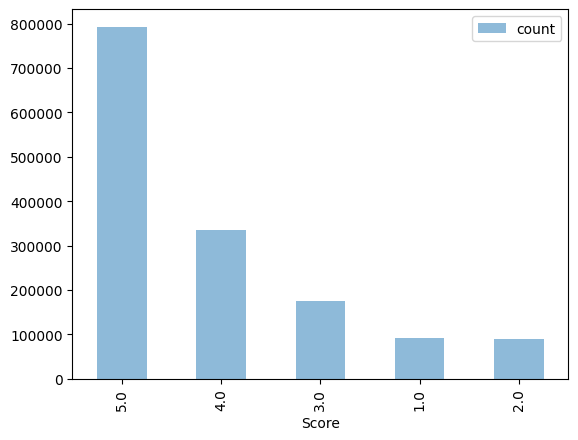


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [18]:
drive.mount('/content/drive')
trainingSet = pd.read_csv("/content/drive/My Drive/train.csv")
testingSet = pd.read_csv("/content/drive/My Drive/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [19]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / (df['HelpfulnessDenominator'] + 1)
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    return df

# Load the feature extracted files if they've already been generated
if exists('/content/drive/My Drive/X_train.csv'):
    X_train = pd.read_csv("/content/drive/My Drive/X_train.csv")
if exists('/content/drive/My Drive/X_submission.csv'):
    X_submission = pd.read_csv("/content/drive/My Drive/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("/content/drive/My Drive/X_submission.csv", index=False)
    X_train.to_csv("/content/drive/My Drive/X_train.csv", index=False)

# Sample + Split into training and testing set

In [20]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [26]:
# ta3reef w ta7deed il-features il-mohemma
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', 'Text']
X_train_select, X_test_select, X_submission_select = (df[features] for df in [X_train, X_test, X_submission])
for df, orig_df in zip([X_train_select, X_test_select, X_submission_select], [X_train, X_test, X_submission]):
    df['Combined_Text'] = orig_df['Summary'].fillna('') + ' ' + orig_df['Text'].fillna('')
# ta7deer w tatbeeq TfidfVectorizer, 300k = 0.56799, 262144 = 0.58602, 0.62
#vectorizer = TfidfVectorizer(max_features=300000, stop_words='english', ngram_range=(1, 2))
vectorizer = TfidfVectorizer(max_features=262144, stop_words='english', ngram_range=(1, 2))
X_train_text, X_test_text, X_submission_text = (vectorizer.fit_transform(X_train_select['Combined_Text']),vectorizer.transform(X_test_select['Combined_Text']),vectorizer.transform(X_submission_select['Combined_Text']))
X_train_help, X_test_help, X_submission_help = (df[['Helpfulness']].fillna(0).to_numpy().repeat(2, axis=1) for df in [X_train_select, X_test_select, X_submission_select])
# dmj features il-nass ma3 features 'Helpfulness' l kol dataset
X_train_combined, X_test_combined, X_submission_combined = (hstack([text, help_matrix]) for text, help_matrix in zip([X_train_text, X_test_text, X_submission_text],[X_train_help, X_test_help, X_submission_help]))

<ipython-input-26-4d7af56ad6aa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Combined_Text'] = orig_df['Summary'].fillna('') + ' ' + orig_df['Text'].fillna('')
<ipython-input-26-4d7af56ad6aa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Combined_Text'] = orig_df['Summary'].fillna('') + ' ' + orig_df['Text'].fillna('')
<ipython-input-26-4d7af56ad6aa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

# Model Creation

In [27]:
model = Perceptron(
    max_iter=3500,
    tol=1e-4,
    n_jobs=-1          # Use all CPU cores
)
# sora3at il-training w istikhdam 2all lil memory
model.fit(X_train_combined, Y_train)
Y_test_predictions = model.predict(X_test_combined)

# Model Evaluation

Accuracy on testing set =  0.5718675269836482


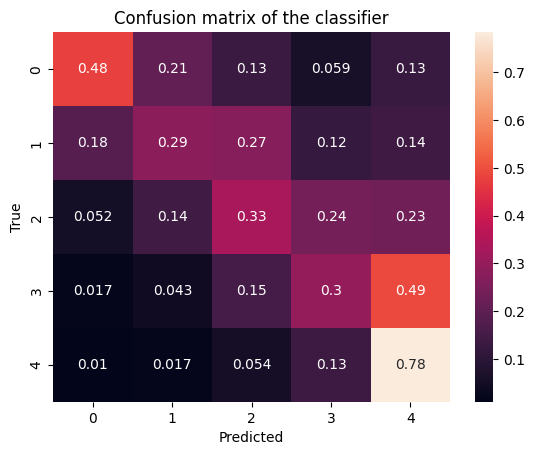

In [28]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [24]:
# Create the submission fdt_
X_submission['Score'] = model.predict(X_submission_combined)
submission = X_submission[['Id', 'Score']]
submission.to_csv("/content/drive/My Drive/submission.csv", index=False)